In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import pandas as pd
import os

from utils import plot_forecasts_shaded, plot_calibration
from energy_utils import get_energy_data, levels as energy_levels, ISO_to_sites
from covid_utils import get_covid_data, levels as covid_levels, good_forecasters
from compute_metrics import replace_inf_values
from multiqt_adapt import MQ_adapt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
fig_folder = "figs"

## COVID case study

In [22]:
def add_dates_to_axis(ax, YYYYMMDD_start):
    # Generate array of strings that looks like ['07-18-20', '07-25-20', ...]. It should be the same length as Y
    start_date = pd.to_datetime(YYYYMMDD_start)
    date_strings = pd.date_range(start=start_date, periods=len(Y), freq='W').strftime('%m-%d-%y').tolist()

    # Subsample to every four weeks
    subsampled_dates = date_strings[::4]
    subsampled_indices = np.arange(0, len(date_strings), 4)

    # Replace labels with '' except for every quarter (4 * 3 weeks)
    labels = [subsampled_dates[s] if s % 3 == 0 else '' for s in range(len(subsampled_dates))]
    ax.set_xticks(subsampled_indices)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.xaxis.set_tick_params(labelsize=8)


/Users/tiffanyding/anaconda3/envs/multilevelqt2/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1518: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


Forecast contains infinite values, replacing -inf with min(smallest observed Y_t in last k time steps, smallest finite current quantile forecast) and +inf with max(largest observed Y_t in last k time steps, largest finite current quantile forecast)
Saving figures to figs/case_studies/covid/


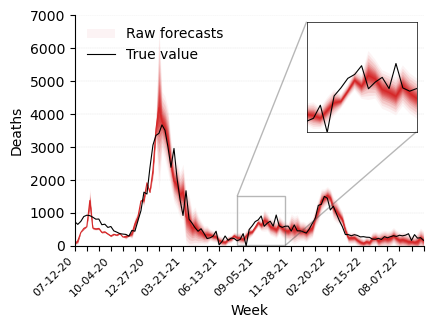

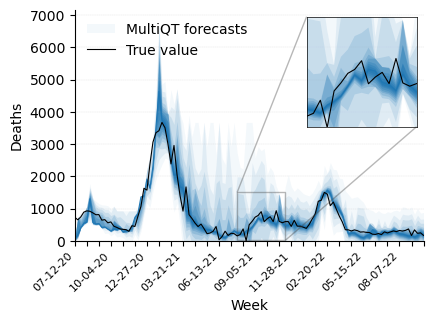

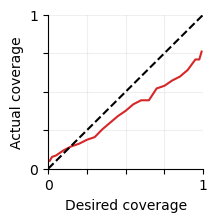

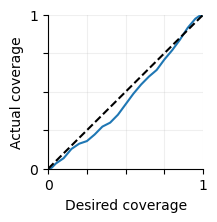

In [82]:

dataset = 'covid'
# ====================
forecaster = 'RobertWalraven-ESG' # Some other options: "COVIDhub-baseline"  #"UA-EpiCovDA", "COVIDhub-ensemble", "RobertWalraven-ESG", good_forecasters[<insert #>]
state = 'ca'
horizon = 1

start_date = '2020-07-11'  # CHECK WHAT THIS IS FOR SELECTED FORECASTER AND HORIZON!

# ====================

forecast_figsize = (4.5, 3)
xlims = None
ylims = None

Yhat_type = 'quantile-specific'  
levels = covid_levels

# Load base forecasts
Y, Yhat_base = get_covid_data(forecaster, state, horizon, Yhat_type=Yhat_type, levels=levels)

# Get MultiQT forecasts

# # Option 1: Load from cache
# calib_path = f"cache/covid/{forecaster}_{state}_Yhat={Yhat_type}_h={horizon}.npy"
# Yhat_calib = np.load(calib_path)

# Option 2: Compute on the fly 
Yhat_calib = MQ_adapt(Y,levels,Yhat_base.T).T

# if needed, transpose Yhat_calib to have shape (T, num_levels)
if Yhat_calib.shape != Yhat_base.shape:
    Yhat_calib = Yhat_calib.T

# Replace inf values in Yhat_calib
Yhat_calib = replace_inf_values(Yhat_calib, Y)


# Make fig folder
os.makedirs(f'{fig_folder}/case_studies/{dataset}', exist_ok=True)
print(f"Saving figures to {fig_folder}/case_studies/{dataset}/")

# Plot raw forecasts
fig, ax = plt.subplots(figsize=forecast_figsize)
plot_forecasts_shaded(Y, Yhat_base, levels, ax=ax, title=None, plot_Y=True,
    linewidth=0.8, base_color="tab:red", alpha_min=0.05, alpha_max=0.4,
    forecast_label='Raw forecasts', xlabel='Week', ylabel=f'Deaths', legend_loc='upper left')
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.xaxis.grid(False) # Remove x-axis grid marks
add_dates_to_axis(ax, start_date)  

# ---- Add an inset ----
axins = inset_axes(ax, width=1.1, height=1.1, loc='upper right')
plot_forecasts_shaded(Y, Yhat_base, levels, ax=axins, title=None, plot_Y=True, linewidth=0.8, base_color="tab:red", alpha_min=0.05, alpha_max=0.4)
axins.set_xlim(54, 70)
axins.set_ylim(10, 1500)
# Remove labels (xticks and axis labels) and legend and xtickmarks
axins.set_xticklabels([])
axins.set_xlabel('')
axins.set_yticklabels([])
axins.set_ylabel('')    
axins.legend_.remove()
axins.set_xticks([])  # Remove xtick marks
axins.set_yticks([])  # Remove xtick marks
# Add top and right spines back in 
axins.spines['top'].set_visible(True)
axins.spines['right'].set_visible(True)
# Make spines gray and thicker
for dir in ['top', 'right', 'left', 'bottom']:
    axins.spines[dir].set_linewidth(0.5)
axins.patch.set_alpha(0.7)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec=(0.3,0.3,0.3,0.4))

plt.savefig(f'{fig_folder}/case_studies/{dataset}/raw_forecasts_{forecaster}_{state}_h={horizon}.pdf', bbox_inches='tight')


# Plot calibrated forecasts
fig, ax = plt.subplots(figsize=forecast_figsize)
plot_forecasts_shaded(Y, Yhat_calib, levels, ax=ax, title=None, plot_Y=True,
    linewidth=0.8, base_color="tab:blue", alpha_min=0.05, alpha_max=0.4,
    forecast_label='MultiQT forecasts', xlabel='Week', ylabel=f'Deaths', legend_loc='upper left')
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.xaxis.grid(False) # Remove x-axis grid marks
add_dates_to_axis(ax, start_date)  

# ---- Add an inset ----
axins = inset_axes(ax, width=1.1, height=1.1, loc='upper right')
plot_forecasts_shaded(Y, Yhat_calib, levels, ax=axins, title=None, plot_Y=True, linewidth=0.8, base_color="tab:blue", alpha_min=0.05, alpha_max=0.4)
axins.set_xlim(54, 70)
axins.set_ylim(10, 1500)
# Remove labels (xticks and axis labels) and legend and xtickmarks
axins.set_xticklabels([])
axins.set_xlabel('')
axins.set_yticklabels([])
axins.set_ylabel('')    
axins.legend_.remove()
axins.set_xticks([])  # Remove xtick marks
axins.set_yticks([])  # Remove xtick marks
# Add top and right spines back in 
axins.spines['top'].set_visible(True)
axins.spines['right'].set_visible(True)
# Make spines gray and thicker
for dir in ['top', 'right', 'left', 'bottom']:
    axins.spines[dir].set_linewidth(0.5)

axins.patch.set_alpha(0.7)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec=(0.3,0.3,0.3,0.4))

plt.savefig(f'{fig_folder}/case_studies/{dataset}/calib_forecasts_{forecaster}_{state}_h={horizon}.pdf', bbox_inches='tight')

# Plot calibration lines
fig, ax = plt.subplots(figsize=(2, 2))
plot_calibration(Y, Yhat_base, ax=ax, color='tab:red', title=None, 
                 single_state=True, plot_yequalsx=True, label='Raw forecasts', alpha=1, levels=levels)
plt.savefig(f'{fig_folder}/case_studies/{dataset}/raw_calibration_{forecaster}_{state}_h={horizon}.pdf', bbox_inches='tight')


fig, ax = plt.subplots(figsize=(2, 2))
plot_calibration(Y, Yhat_calib, ax=ax, color='tab:blue', title=None,
                    single_state=True, plot_yequalsx=True, label='Calibrated forecasts', alpha=1, levels=levels)
plt.savefig(f'{fig_folder}/case_studies/{dataset}/calib_calibration_{forecaster}_{state}_h={horizon}.pdf', bbox_inches='tight')

In [5]:
dataset = 'energy'

ISO = 'ERCOT'
levels = energy_levels

target_variable = 'Wind'
site = 'Wind_Power_Partners_94_Wind_Farm' 
# Other wind sites: 'Desert_Sky_Repower', 'Buckthorn' 'Aguayo_Wind', 'Gusty_Hill_Wind', 'Sweetwater_1_Repower', ISO_to_sites[ISO][target_variable][<insert #>]
# Solar sites: 'Hecate_Solar', 'IP_Titan', 'Citrine_Solar', ISO_to_sites[ISO][target_variable][<insert #>]
print(f"Site: {site}")


hour = 16 # Options: 0, 4, 8, 12, 16, 20

Y, Yhat_base = get_energy_data(ISO, site, hour=hour, target_variable=target_variable)

calib_path = f"cache/energy/{ISO}_{site}_{target_variable}_Yhat=quantile-specific_hour={hour}.npy"
Yhat_calib = np.load(calib_path)

Site: Wind_Power_Partners_94_Wind_Farm


FileNotFoundError: [Errno 2] No such file or directory: 'cache/energy/ERCOT_Wind_Power_Partners_94_Wind_Farm_Wind_Yhat=quantile-specific_hour=16.npy'

Saving figures to figs/case_studies/energy/


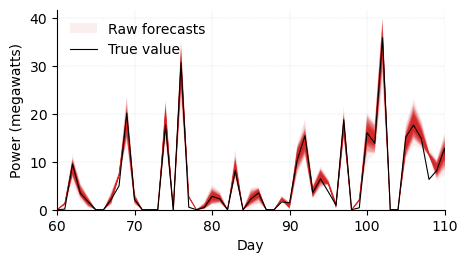

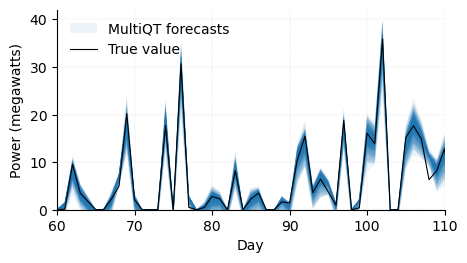

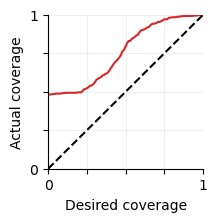

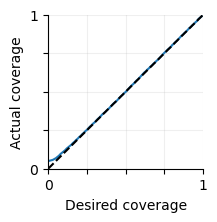

In [ ]:
# xlims = (243, 303) # Sept 1 - Oct 31
xlims = (60, 110)
ylims = None

# Make fig folder
os.makedirs(f'{fig_folder}/case_studies/{dataset}', exist_ok=True)
print(f"Saving figures to {fig_folder}/case_studies/{dataset}/")

# Plot raw forecasts
fig, ax = plt.subplots(figsize=(5, 2.6))
plot_forecasts_shaded(Y, Yhat_base, levels, ax=ax, title=None, plot_Y=True,
    linewidth=0.8, base_color="tab:red",
    forecast_label='Raw forecasts', xlabel='Day', ylabel=f'Power (megawatts)', legend_loc='upper left')
ax.set_xlim(xlims)
ax.set_ylim(ylims)
plt.savefig(f'{fig_folder}/case_studies/{dataset}/raw_forecasts_{target_variable}_{site}_{hour=}.pdf', bbox_inches='tight')

# Plot calibrated forecasts
fig, ax = plt.subplots(figsize=(5, 2.6))
plot_forecasts_shaded(Y, Yhat_calib, levels, ax=ax, title=None, plot_Y=True,
    linewidth=0.8, base_color="tab:blue", 
    forecast_label='MultiQT forecasts', xlabel='Day', ylabel=f'Power (megawatts)', legend_loc='upper left')
ax.set_xlim(xlims)
ax.set_ylim(ylims)
plt.savefig(f'{fig_folder}/case_studies/{dataset}/calib_forecasts_{target_variable}_{site}_{hour=}.pdf', bbox_inches='tight')

# Plot calibration lines
fig, ax = plt.subplots(figsize=(2, 2))
plot_calibration(Y, Yhat_base, ax=ax, color='tab:red', title=None, 
                 single_state=True, plot_yequalsx=True, label='Raw forecasts', alpha=1, levels=levels)
plt.savefig(f'{fig_folder}/case_studies/{dataset}/raw_calibration_{target_variable}_{site}_{hour=}.pdf', bbox_inches='tight')


fig, ax = plt.subplots(figsize=(2, 2))
plot_calibration(Y, Yhat_calib, ax=ax, color='tab:blue', title=None,
                    single_state=True, plot_yequalsx=True, label='Calibrated forecasts', alpha=1, levels=levels)
plt.savefig(f'{fig_folder}/case_studies/{dataset}/calib_calibration_{target_variable}_{site}_{hour=}.pdf', bbox_inches='tight')
